Adsorption Energies
======================================================

Pre-trained ODAC models are versatile across various MOF-related tasks. To begin, we'll start with a fundamental application: calculating the adsorption energy for a single CO<sub>2</sub> molecule. This serves as an excellent and simple demonstration of what you can achieve with these datasets and models.

For predicting the adsorption energy of a single CO<sub>2</sub> molecule within a MOF structure, the adsorption energy ($E_{\mathrm{ads}}$) is defined as:

$$ E_{\mathrm{ads}} = E_{\mathrm{MOF+CO2}} - E_{\mathrm{MOF}} - E_{\mathrm{CO2}} \tag{1}$$

Each term on the right-hand side represents the energy of the relaxed state of the indicated chemical system. For a comprehensive understanding of our methodology for computing these adsorption energies, please refer to our [paper](https://doi.org/10.1021/acscentsci.3c01629).

## Loading Pre-trained Models

````{admonition} Need to install fairchem-core or get UMA access or getting permissions/401 errors?
:class: dropdown


1. Install the necessary packages using pip, uv etc
```{code-cell} ipython3
:tags: [skip-execution]

! pip install fairchem-core fairchem-data-oc fairchem-applications-cattsunami
```

2. Get access to any necessary huggingface gated models
    * Get and login to your Huggingface account
    * Request access to https://huggingface.co/facebook/UMA
    * Create a Huggingface token at https://huggingface.co/settings/tokens/ with the permission "Permissions: Read access to contents of all public gated repos you can access"
    * Add the token as an environment variable using `huggingface-cli login` or by setting the HF_TOKEN environment variable.

```{code-cell} ipython3
:tags: [skip-execution]

# Login using the huggingface-cli utility
! huggingface-cli login

# alternatively,
import os
os.environ['HF_TOKEN'] = 'MY_TOKEN'
```

````


A pre-trained model can be loaded using `FAIRChemCalculator`. In this example, we'll employ UMA to determine the CO<sub>2</sub> adsorption energies.

In [1]:
from fairchem.core import FAIRChemCalculator, pretrained_mlip

predictor = pretrained_mlip.get_predict_unit("uma-s-1p1")
calc = FAIRChemCalculator(predictor, task_name="odac")

## Adsorption in rigid MOFs: CO<sub>2</sub> Adsorption Energy in Mg-MOF-74

Let's apply our knowledge to Mg-MOF-74, a widely studied MOF known for its excellent CO<sub>2</sub> adsorption properties. Its structure comprises magnesium atomic complexes connected by a carboxylated and oxidized benzene ring, serving as an organic linker. Previous studies consistently report the CO<sub>2</sub> adsorption energy for Mg-MOF-74 to be around -0.40 eV [[1]](https://doi.org/10.1039/C4SC02064B) [[2]](https://doi.org/10.1039/C3SC51319J) [[3]](https://doi.org/10.1021/acs.jpcc.8b00938).

Our goal is to verify if we can achieve a similar value by performing a simple single-point calculation using UMA. In the ODAC23 dataset, all MOF structures are identified by their CSD (Cambridge Structural Database) code. For Mg-MOF-74, this code is **OPAGIX**. We've extracted a specific `OPAGIX+CO2` configuration from the dataset, which exhibits the lowest adsorption energy among its counterparts.

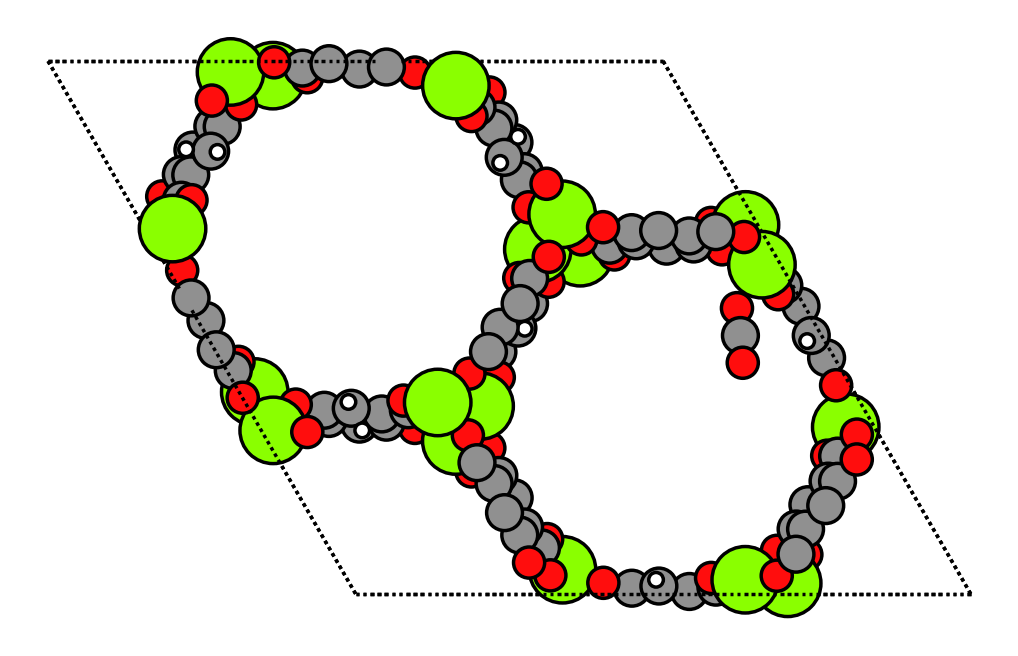

In [2]:
import matplotlib.pyplot as plt
from ase.io import read
from ase.visualize.plot import plot_atoms

mof_co2 = read("structures/OPAGIX_w_CO2.cif")
mof = read("structures/OPAGIX.cif")
co2 = read("structures/co2.xyz")

fig, ax = plt.subplots(figsize=(5, 4.5), dpi=250)
plot_atoms(mof_co2, ax)
ax.set_axis_off()

The final step in calculating the adsorption energy involves connecting the `FAIRChemCalculator` to each relaxed structure: `OPAGIX+CO2`, `OPAGIX`, and `CO2`. The structures used here are already relaxed from ODAC23. For simplicity, we assume here that further relaxations can be neglected. We will show how to go beyond this assumption in the next section.

In [3]:
mof_co2.calc = calc
mof.calc = calc
co2.calc = calc

E_ads = (
    mof_co2.get_potential_energy()
    - mof.get_potential_energy()
    - co2.get_potential_energy()
)

print(f"Adsorption energy of CO2 in Mg-MOF-74: {E_ads:.3f} eV")

Adsorption energy of CO2 in Mg-MOF-74: -0.459 eV


## Adsorption in flexible MOFs

The adsorption energy calculation method outlined above is typically performed with rigid MOFs for simplicity. Both experimental and modeling literature have shown, however, that MOF flexibility can be important in accurately capturing the underlying chemistry of adsorption [[1]](https://arxiv.org/abs/2506.09256) [[2]](https://pubs.acs.org/doi/10.1021/jacs.7b01688) [[3]](https://www.nature.com/articles/nature15732). In particular, uptake can be improved by treating MOFs as flexible. Two types of MOF flexibility can be considered: intrinsic flexibility and deformation induced by guest molecules. In the Open DAC Project, we consider the latter MOF deformation by allowing the atomic positions of the MOF to relax during geometry optimization [[4]](https://pubs.acs.org/doi/10.1021/acscentsci.3c01629). The addition of additional degrees of freedoms can complicate the computation of the adsorption energy and necessitates an extra step in the calculation procedure.

The figure below shows water adsorption in the MOF with CSD code WOBHEB with added defects (`WOBHEB_0.11_0`) from a DFT simulation. A typical adsorption energy calculation would only seek to capture the effects shaded in purple, which include both chemisorption and non-bonded interactions between the host and guest molecule. When allowing the MOF to relax, however, the adsorption energy also includes the energetic effect of the MOF deformation highlighted in green.

![](./WOBHEB_flexible.png)

To account for this deformation, it is vital to use the most energetically favorable MOF geometry for the empty MOF term in Eqn. 1. Including MOF atomic coordinates as degrees of freedom can result in three possible outcomes:

1. The MOF does not deform, so the energies of the relaxed empty MOF and the MOF in the adsorbed state are the same
2. The MOF deforms to a less energetically favorable geometry than its ground state
3. The MOF locates a new energetically favorable geoemtry relative to the empty MOF relaxation

The first outcome requires no additional computation because the MOF rigidity assumption is valid. The second outcome represents physical and reversible deformation where the MOF returns to its empty ground state upon removal of the guest molecule. The third outcome is often the result of the guest molecule breaking local symmetry. We also found cases in ODAC in which both outcomes 2 and 3 occur within the same MOF.

To ensure the most energetically favorable empty MOF geometry is found, an addition empty MOF relaxation should be performed after MOF + adsorbate relaxation. The guest molecule should be removed, and the MOF should be relaxed starting from its geometry in the adsorbed state. If all deformation is reversible, the MOF will return to its original empty geometry. Otherwise, the lowest energy (most favorable) MOF geometry should be taken as the reference energy, $E_{\mathrm{MOF}}$, in Eqn. 1.

### H<sub>2</sub>O Adsorption Energy in Flexible WOBHEB with UMA

The first part of this tutorial demonstrates how to perform a single point adsorption energy calculation using UMA. To treat MOFs as flexible, we perform all calculations on geometries determined by geometry optimization. The following example corresponds to the figure shown above (H<sub>2</sub>O adsorption in `WOBHEB_0.11_0`).

**In this tutorial, $E_{x}(r_{y})$ corresponds to the energy of $x$ determined from geometry optimization of $y$.**

First, we obtain the energy of the empty MOF from relaxation of only the MOF: $E_{\mathrm{MOF}}(r_{\mathrm{MOF}})$

In [4]:
import ase.io
from ase.optimize import BFGS

mof = ase.io.read("structures/WOBHEB_0.11.cif")
mof.calc = calc
relax = BFGS(mof)
relax.run(fmax=0.05)
E_mof_empty = mof.get_potential_energy()
print(f"Energy of empty MOF: {E_mof_empty:.3f} eV")

      Step     Time          Energy          fmax
BFGS:    0 01:04:25    -1077.274063        0.206406


BFGS:    1 01:04:25    -1077.276780        0.152729


BFGS:    2 01:04:25    -1077.281941        0.169932


BFGS:    3 01:04:26    -1077.284770        0.155758


BFGS:    4 01:04:26    -1077.288836        0.108770


BFGS:    5 01:04:26    -1077.291022        0.086437


BFGS:    6 01:04:26    -1077.293358        0.093442


BFGS:    7 01:04:27    -1077.295412        0.100109


BFGS:    8 01:04:27    -1077.297830        0.102523


BFGS:    9 01:04:27    -1077.300017        0.091599


BFGS:   10 01:04:27    -1077.302008        0.079012


BFGS:   11 01:04:27    -1077.304135        0.105563


BFGS:   12 01:04:28    -1077.306721        0.087958


BFGS:   13 01:04:28    -1077.309514        0.086352


BFGS:   14 01:04:28    -1077.312263        0.086841


BFGS:   15 01:04:28    -1077.314700        0.106285


BFGS:   16 01:04:29    -1077.316989        0.106202


BFGS:   17 01:04:29    -1077.319485        0.085520


BFGS:   18 01:04:29    -1077.322261        0.109635


BFGS:   19 01:04:29    -1077.325134        0.148702


BFGS:   20 01:04:29    -1077.327766        0.125931


BFGS:   21 01:04:30    -1077.329919        0.069109


BFGS:   22 01:04:30    -1077.331952        0.087281


BFGS:   23 01:04:30    -1077.334273        0.125239


BFGS:   24 01:04:30    -1077.336834        0.166696


BFGS:   25 01:04:31    -1077.339539        0.145554


BFGS:   26 01:04:31    -1077.342148        0.087698


BFGS:   27 01:04:31    -1077.344541        0.076153


BFGS:   28 01:04:31    -1077.346894        0.148962


BFGS:   29 01:04:32    -1077.349783        0.170215


BFGS:   30 01:04:32    -1077.352532        0.109283


BFGS:   31 01:04:32    -1077.354746        0.070304


BFGS:   32 01:04:32    -1077.356779        0.089710


BFGS:   33 01:04:32    -1077.358656        0.124277


BFGS:   34 01:04:33    -1077.360599        0.108023


BFGS:   35 01:04:33    -1077.362466        0.068640


BFGS:   36 01:04:33    -1077.364163        0.070236


BFGS:   37 01:04:33    -1077.365713        0.105423


BFGS:   38 01:04:34    -1077.367262        0.104331


BFGS:   39 01:04:34    -1077.368767        0.062679


BFGS:   40 01:04:34    -1077.370132        0.057594


BFGS:   41 01:04:34    -1077.371351        0.063208


BFGS:   42 01:04:34    -1077.372400        0.066338


BFGS:   43 01:04:35    -1077.373375        0.058170


BFGS:   44 01:04:35    -1077.374369        0.042558
Energy of empty MOF: -1077.374 eV


Next, we add the H<sub>2</sub>O guest molecule and relax the MOF + adsorbate to obtain $E_{\mathrm{MOF+H2O}}(r_{\mathrm{MOF+H2O}})$.

In [5]:
mof_h2o = ase.io.read("structures/WOBHEB_H2O.cif")
mof_h2o.calc = calc
relax = BFGS(mof_h2o)
relax.run(fmax=0.05)
E_combo = mof_h2o.get_potential_energy()
print(f"Energy of MOF + H2O: {E_combo:.3f} eV")

      Step     Time          Energy          fmax
BFGS:    0 01:04:35    -1091.565589        1.145035


BFGS:    1 01:04:36    -1091.585062        0.314149


BFGS:    2 01:04:36    -1091.590211        0.243429


BFGS:    3 01:04:36    -1091.608166        0.237258


BFGS:    4 01:04:36    -1091.614635        0.227935


BFGS:    5 01:04:36    -1091.625221        0.186784


BFGS:    6 01:04:37    -1091.632354        0.178915


BFGS:    7 01:04:37    -1091.640629        0.175097


BFGS:    8 01:04:37    -1091.648040        0.184530


BFGS:    9 01:04:37    -1091.656144        0.160897


BFGS:   10 01:04:38    -1091.663842        0.178428


BFGS:   11 01:04:38    -1091.672296        0.188664


BFGS:   12 01:04:38    -1091.682088        0.157518


BFGS:   13 01:04:38    -1091.692980        0.177249


BFGS:   14 01:04:39    -1091.704436        0.158145


BFGS:   15 01:04:39    -1091.715510        0.191578


BFGS:   16 01:04:39    -1091.725708        0.197917


BFGS:   17 01:04:39    -1091.735329        0.163707


BFGS:   18 01:04:39    -1091.745539        0.151507


BFGS:   19 01:04:40    -1091.754025        0.170791


BFGS:   20 01:04:40    -1091.761501        0.153481


BFGS:   21 01:04:40    -1091.767896        0.152964


BFGS:   22 01:04:40    -1091.774204        0.166105


BFGS:   23 01:04:41    -1091.780881        0.135311


BFGS:   24 01:04:41    -1091.788357        0.180955


BFGS:   25 01:04:41    -1091.794276        0.204546


BFGS:   26 01:04:41    -1091.800638        0.131428


BFGS:   27 01:04:42    -1091.806518        0.190246


BFGS:   28 01:04:42    -1091.812301        0.199168


BFGS:   29 01:04:42    -1091.817175        0.151707


BFGS:   30 01:04:42    -1091.822211        0.100095


BFGS:   31 01:04:42    -1091.826303        0.125354


BFGS:   32 01:04:43    -1091.832526        0.177278


BFGS:   33 01:04:43    -1091.837115        0.246554


BFGS:   34 01:04:43    -1091.842046        0.112795


BFGS:   35 01:04:43    -1091.845771        0.330359


BFGS:   36 01:04:44    -1091.850858        0.174373


BFGS:   37 01:04:44    -1091.858477        0.159571


BFGS:   38 01:04:44    -1091.865278        0.141406


BFGS:   39 01:04:44    -1091.872013        0.140723


BFGS:   40 01:04:45    -1091.878289        0.256261


BFGS:   41 01:04:45    -1091.880359        0.573935


BFGS:   42 01:04:45    -1091.886689        0.598300


BFGS:   43 01:04:45    -1091.893840        0.233992


BFGS:   44 01:04:45    -1091.899714        0.165898


BFGS:   45 01:04:46    -1091.916474        0.233811


BFGS:   46 01:04:46    -1091.924607        0.392517


BFGS:   47 01:04:46    -1091.938669        0.285455


BFGS:   48 01:04:46    -1091.954637        0.380339


BFGS:   49 01:04:47    -1091.976325        0.567486


BFGS:   50 01:04:47    -1091.968402        1.447761


BFGS:   51 01:04:47    -1092.005191        0.296166


BFGS:   52 01:04:47    -1092.021562        0.282093


BFGS:   53 01:04:48    -1092.069826        0.320528


BFGS:   54 01:04:48    -1092.086256        0.279802


BFGS:   55 01:04:48    -1092.119633        0.392001


BFGS:   56 01:04:48    -1092.128203        0.524737


BFGS:   57 01:04:48    -1092.142428        0.240410


BFGS:   58 01:04:49    -1092.156705        0.251282


BFGS:   59 01:04:49    -1092.172064        0.281163


BFGS:   60 01:04:49    -1092.180932        0.299147


BFGS:   61 01:04:49    -1092.194212        0.375060


BFGS:   62 01:04:50    -1092.204687        0.392457


BFGS:   63 01:04:50    -1092.216302        0.321046


BFGS:   64 01:04:50    -1092.225593        0.219276


BFGS:   65 01:04:50    -1092.233067        0.113352


BFGS:   66 01:04:51    -1092.238972        0.109057


BFGS:   67 01:04:51    -1092.244556        0.130557


BFGS:   68 01:04:51    -1092.250149        0.137394


BFGS:   69 01:04:51    -1092.255160        0.115577


BFGS:   70 01:04:52    -1092.260370        0.077526


BFGS:   71 01:04:52    -1092.264859        0.092164


BFGS:   72 01:04:52    -1092.268785        0.117080


BFGS:   73 01:04:52    -1092.272441        0.148454


BFGS:   74 01:04:52    -1092.275889        0.171040


BFGS:   75 01:04:53    -1092.279152        0.168133


BFGS:   76 01:04:53    -1092.282710        0.121859


BFGS:   77 01:04:53    -1092.285368        0.092823


BFGS:   78 01:04:53    -1092.287917        0.091796


BFGS:   79 01:04:54    -1092.290296        0.088252


BFGS:   80 01:04:54    -1092.292212        0.097478


BFGS:   81 01:04:54    -1092.293978        0.069326


BFGS:   82 01:04:54    -1092.295327        0.079321


BFGS:   83 01:04:55    -1092.296744        0.067608


BFGS:   84 01:04:55    -1092.298136        0.079335


BFGS:   85 01:04:55    -1092.299811        0.068047


BFGS:   86 01:04:55    -1092.301462        0.087849


BFGS:   87 01:04:55    -1092.303193        0.091868


BFGS:   88 01:04:56    -1092.304955        0.072845


BFGS:   89 01:04:56    -1092.306425        0.059202


BFGS:   90 01:04:56    -1092.307840        0.048124
Energy of MOF + H2O: -1092.308 eV


We can now isolate the MOF atoms from the relaxed MOF + H<sub>2</sub>O geometry and see that the MOF has adopted a geometry that is less energetically favorable than the empty MOF by ~0.2 eV. The energy of the MOF in the adsorbed state corresponds to $E_{\mathrm{MOF}}(r_{\mathrm{MOF+H2O}})$.

In [6]:
mof_adsorbed_state = mof_h2o[:-3]
mof_adsorbed_state.calc = calc
E_mof_adsorbed_state = mof_adsorbed_state.get_potential_energy()
print(f"Energy of MOF in the adsorbed state: {E_mof_adsorbed_state:.3f} eV")

Energy of MOF in the adsorbed state: -1077.091 eV


H<sub>2</sub>O adsorption in this MOF appears to correspond to Case #2 as outlined above. We can now perform re-relaxation of the empty MOF starting from the $r_{\mathrm{MOF+H2O}}$ geometry.

In [7]:
relax = BFGS(mof_adsorbed_state)
relax.run(fmax=0.05)
E_mof_rerelax = mof_adsorbed_state.get_potential_energy()
print(f"Energy of re-relaxed empty MOF: {E_mof_rerelax:.3f} eV")

      Step     Time          Energy          fmax
BFGS:    0 01:04:56    -1077.090543        0.983064


BFGS:    1 01:04:57    -1077.122933        0.871592


BFGS:    2 01:04:57    -1077.172657        0.804411


BFGS:    3 01:04:57    -1077.212383        0.501899


BFGS:    4 01:04:57    -1077.232091        0.437998


BFGS:    5 01:04:58    -1077.249996        0.283337


BFGS:    6 01:04:58    -1077.260788        0.260156


BFGS:    7 01:04:58    -1077.270253        0.246364


BFGS:    8 01:04:58    -1077.279580        0.211165


BFGS:    9 01:04:58    -1077.286627        0.184081


BFGS:   10 01:04:59    -1077.291797        0.150346


BFGS:   11 01:04:59    -1077.295877        0.139581


BFGS:   12 01:04:59    -1077.299506        0.146104


BFGS:   13 01:04:59    -1077.304175        0.186004


BFGS:   14 01:05:00    -1077.308922        0.174195


BFGS:   15 01:05:00    -1077.313511        0.134374


BFGS:   16 01:05:00    -1077.317622        0.164361


BFGS:   17 01:05:00    -1077.321827        0.151382


BFGS:   18 01:05:00    -1077.326196        0.145894


BFGS:   19 01:05:01    -1077.329754        0.113721


BFGS:   20 01:05:01    -1077.332376        0.108615


BFGS:   21 01:05:01    -1077.334623        0.100219


BFGS:   22 01:05:01    -1077.336910        0.122771


BFGS:   23 01:05:02    -1077.339616        0.119022


BFGS:   24 01:05:02    -1077.342237        0.089192


BFGS:   25 01:05:02    -1077.344566        0.091094


BFGS:   26 01:05:02    -1077.346477        0.068069


BFGS:   27 01:05:03    -1077.348031        0.068180


BFGS:   28 01:05:03    -1077.349736        0.090414


BFGS:   29 01:05:03    -1077.351286        0.095445


BFGS:   30 01:05:03    -1077.352896        0.063985


BFGS:   31 01:05:03    -1077.354077        0.050641


BFGS:   32 01:05:04    -1077.355386        0.054131


BFGS:   33 01:05:04    -1077.356746        0.083935


BFGS:   34 01:05:04    -1077.358141        0.078658


BFGS:   35 01:05:04    -1077.359669        0.068525


BFGS:   36 01:05:05    -1077.361074        0.070997


BFGS:   37 01:05:05    -1077.362351        0.073804


BFGS:   38 01:05:05    -1077.363524        0.084000


BFGS:   39 01:05:05    -1077.364853        0.080880


BFGS:   40 01:05:06    -1077.365839        0.067205


BFGS:   41 01:05:06    -1077.366863        0.058414


BFGS:   42 01:05:06    -1077.367945        0.060002


BFGS:   43 01:05:06    -1077.368982        0.070058


BFGS:   44 01:05:06    -1077.370235        0.076270


BFGS:   45 01:05:07    -1077.371393        0.048681
Energy of re-relaxed empty MOF: -1077.371 eV


The MOF returns to its original empty reference energy upon re-relaxation, confirming that this deformation is physically relevant and is induced by the adsorbate molecule. In Case #3, this re-relaxed energy will be more negative (more favorable) than the original empty MOF relaxation. Thus, we take the reference empty MOF energy ($E_{\mathrm{MOF}}$ in Eqn. 1) to be the minimum of the original empty MOF energy and the re-relaxed MOf energy:

In [8]:
E_mof = min(E_mof_empty, E_mof_rerelax)

# get adsorbate reference energy
h2o = mof_h2o[-3:]
h2o.calc = calc
E_h2o = h2o.get_potential_energy()

# compute adsorption energy
E_ads = E_combo - E_mof - E_h2o
print(f"Adsorption energy of H2O in WOBHEB_0.11_0: {E_ads:.3f} eV")

Adsorption energy of H2O in WOBHEB_0.11_0: -0.685 eV


This adsorption energy closely matches that from DFT (–0.699 eV) [[1]](https://arxiv.org/abs/2506.09256). The strong adsorption energy is a consequence of both H<sub>2</sub>O chemisorption and MOF deformation. We can decompose the adsorption energy into contributions from these two factors. Assuming rigid H<sub>2</sub>O molecules, we define $E_{\mathrm{int}}$ and $E_{\mathrm{MOF,deform}}$, respectively, as

$$ E_{\mathrm{int}} = E_{\mathrm{MOF+H2O}}(r_{\mathrm{MOF+H2O}}) - E_{\mathrm{MOF}}(r_{\mathrm{MOF+H2O}}) - E_{\mathrm{H2O}}(r_{\mathrm{MOF+H2O}}) \tag{2}$$


$$ E_{\mathrm{MOF,deform}} = E_{\mathrm{MOF}}(r_{\mathrm{MOF+H2O}}) - E_{\mathrm{MOF}}(r_{\mathrm{MOF}}) \tag{3}$$


$E_{\mathrm{int}}$ describes host host–guest interactions for the MOF in the adsorbed state only. $E_{\mathrm{MOF,deform}}$ quantifies the magnitude of deformation between the MOF in the adsorbed state and the most energetically favorable empty MOF geometry determined from the workflow presented here. It can be shown that

$$ E_{\mathrm{ads}} = E_{\mathrm{int}} + E_{\mathrm{MOF,deform}} \tag{4}$$

For H<sub>2</sub>O adsorption in `WOBHEB_0.11`, we have

In [9]:
E_int = E_combo - E_mof_adsorbed_state - E_h2o
print(f"E_int: {E_int}")

E_int: -0.9692673683162365


In [10]:
E_mof_deform = E_mof_adsorbed_state - E_mof_empty
print(f"E_mof_deform: {E_mof_deform}")

E_mof_deform: 0.2838258743286133


In [11]:
E_ads = E_int + E_mof_deform
print(f"E_ads: {E_ads}")

E_ads: -0.6854414939876232


$E_{\mathrm{int}}$ is equivalent to $E_{\mathrm{ads}}$ when the MOF is assumed to be rigid. In this case, failure to consider adsorbate-induced deformation would result in an overestimation of the adsorption energy magnitude.

## Acknowledgements & Authors

Logan Brabson and Sihoon Choi (Georgia Tech) and the OpenDAC project.